In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()
#

,amount,fee,transfer_type_regular,stat_cr_canceled,stat_cr_direct_debit_rejected,stat_cr_direct_debit_sent,stat_cr_money_back,stat_cr_rejected,stat_cr_transaction_declined,stat_fe_cancelled,stat_fe_confirmed,stat_fe_cr_regular,stat_fe_rejected,recovery_status_completed,recovery_status_nice,recovery_status_pending,recovery_status_pending_direct_debit,category_nice,category_rejected_direct_debit
0,1.0,0.0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,100.0,0.0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0


                             Predictores  Mínimo  Máximo      Media  \
0                                 amount     1.0   200.0  83.516733   
1                                    fee     0.0    10.0   3.280568   
2                  transfer_type_regular     0.0     1.0   0.392746   
3                       stat_cr_canceled     0.0     1.0   0.001091   
4          stat_cr_direct_debit_rejected     0.0     1.0   0.060482   
5              stat_cr_direct_debit_sent     0.0     1.0   0.002306   
6                     stat_cr_money_back     0.0     1.0   0.725041   
7                       stat_cr_rejected     0.0     1.0   0.204662   
8           stat_cr_transaction_declined     0.0     1.0   0.001496   
9                      stat_fe_cancelled     0.0     1.0   0.153745   
10                     stat_fe_confirmed     0.0     1.0   0.002742   
11                    stat_fe_cr_regular     0.0     1.0   0.343917   
12                      stat_fe_rejected     0.0     1.0   0.037206   
13    

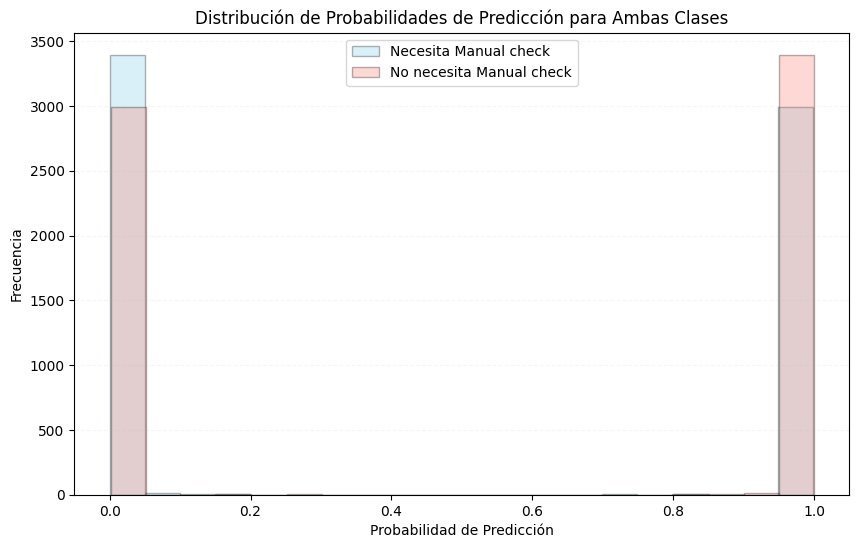

predicciones_probabilidades:
 [[9.98084545e-01 1.91545537e-03]
 [6.20038597e-05 9.99937996e-01]
 [9.75534372e-02 9.02446563e-01]
 [9.98084545e-01 1.91545537e-03]
 [3.73288700e-03 9.96267113e-01]
 [1.70666018e-03 9.98293340e-01]
 [3.78447783e-03 9.96215522e-01]
 [5.67989607e-04 9.99432010e-01]
 [1.66954622e-03 9.98330454e-01]
 [5.58013436e-03 9.94419866e-01]]

Coeficientes del modelo de regresión logística (ordenados por magnitud):
stat_fe_cancelled: 11.4388
stat_cr_rejected: 7.2076
recovery_status_completed: 6.7320
stat_cr_money_back: -5.6134
recovery_status_nice: -5.0969
stat_cr_transaction_declined: 3.2852
stat_fe_rejected: 2.8696
stat_cr_canceled: 2.6274
stat_fe_cr_regular: 2.0656
stat_cr_direct_debit_rejected: 1.8664
category_nice: -0.8028
stat_cr_direct_debit_sent: -0.7689
category_rejected_direct_debit: 0.6931
fee: 0.6124
recovery_status_pending: 0.4820
stat_fe_confirmed: -0.4180
transfer_type_regular: 0.4039
recovery_status_pending_direct_debit: 0.1095
amount: -0.0003


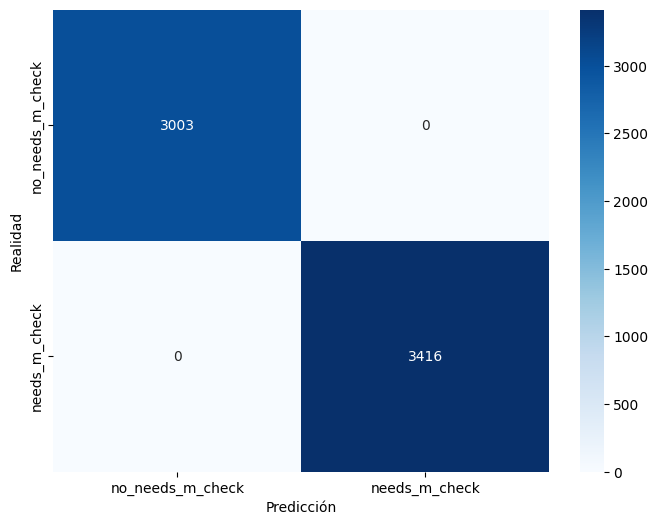

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3003
           1       1.00      1.00      1.00      3416

    accuracy                           1.00      6419
   macro avg       1.00      1.00      1.00      6419
weighted avg       1.00      1.00      1.00      6419



In [2]:
df = df_jo.copy()
# Convertir columnas datetime a timestamps
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

df['moderada'] = df['moderated_at'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# Variables predictoras (ajusta según los datos disponibles)
columnas = ['amount','fee', 'transfer_type', 'stat_cr','stat_fe', 'recovery_status','category']
X = df[columnas].copy()
# Categoricas
X = pd.get_dummies(X, columns=['transfer_type', 'stat_cr', 'stat_fe', 'recovery_status','category'], drop_first=True, dtype=int)

y = df['needs_m_check_recov'].copy()  #moderada # La columna de la variable objetivo
display(X.head(2))
feature_names=X.columns
X_stat=X.copy()
X_stat=X_stat.to_numpy()
# Crear una lista para almacenar los resultados
resultados = []

# Iterar sobre los predictores y calcular las estadísticas
for i, feat in enumerate(feature_names):
    minimo = np.min(X_stat[:, i])
    maximo = np.max(X_stat[:, i])
    media = np.mean(X_stat[:, i])
    varianza = np.var(X_stat[:, i])
    # Añadir los resultados a la lista
    resultados.append([feat, minimo, maximo, media, varianza])

# Crear un DataFrame para mostrar los resultados
df_estadisticas = pd.DataFrame(resultados, columns=['Predictores', 'Mínimo','Máximo', 'Media', 'Varianza'])
# Mostrar el DataFrame
print(df_estadisticas)


#feature_names = X.columns # Obtener los nombres de las características
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train) # Entrena el clasificador
predicciones = clf.predict(X_test) # Realiza predicciones sobre el conjunto de prueba

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Muestra las primeras 10 probabilidades de predicción
print(f"predicciones_probabilidades:\n {predicciones_probabilidades[:10]}\n")

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()
# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report    

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Realizar predicciones sobre el conjunto de prueba
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train) # Predicciones sobre el conjunto de entrenamiento


In [5]:
#Evaluar el modelo utilizando métricas de desempeño
mse_train = mean_squared_error(y_train, y_train_pred) # Error cuadrático medio␣para entrenamiento
mse_test = mean_squared_error(y_test, y_test_pred) # Error cuadrático medio␣para prueba
r2score_train = clf.score(X_train, y_train) # Puntaje R^2 en entrenamiento
r2score_test = clf.score(X_test, y_test) # Puntaje R^2 en prueba
# Mostrar el intercepto y los coeficientes del modelo
print('Intercepto y coeficientes del modelo:\n \nIntercepto: {}\n␣\nCoeficientes: {}'.format(clf.intercept_, clf.coef_))
# Mostrar el error cuadrático medio y el puntaje R^2
print('\nError Cuadrático Medio (ECM) en entrenamiento: {}'.format(mse_train))
print('Error Cuadrático Medio (ECM) en prueba: {}'.format(mse_test))
print('\nPuntaje R^2 en entrenamiento: {}'.format(r2score_train))
print('Puntaje R^2 en prueba: {}'.format(r2score_test))

Intercepto y coeficientes del modelo:
 
Intercepto: [2.22661672]
␣
Coeficientes: [[-3.14623750e-04  6.12420405e-01  4.03886816e-01  2.62743182e+00
   1.86642061e+00 -7.68903757e-01 -5.61341062e+00  7.20763676e+00
   3.28517718e+00  1.14388293e+01 -4.17996019e-01  2.06562690e+00
   2.86961657e+00  6.73202912e+00 -5.09690919e+00  4.82046336e-01
   1.09450458e-01 -8.02819168e-01  6.93077599e-01]]

Error Cuadrático Medio (ECM) en entrenamiento: 7.790285513964086e-05
Error Cuadrático Medio (ECM) en prueba: 0.0

Puntaje R^2 en entrenamiento: 0.9999220971448604
Puntaje R^2 en prueba: 1.0


In [6]:
# Obtener los coeficientes de regresión
display(feature_names)
coefs_clf = pd.Series(np.abs(clf.coef_[0]), index=feature_names).sort_values() # Valores␣absolutos para ordenarlos

Index(['amount', 'fee', 'transfer_type_regular', 'stat_cr_canceled',
       'stat_cr_direct_debit_rejected', 'stat_cr_direct_debit_sent',
       'stat_cr_money_back', 'stat_cr_rejected',
       'stat_cr_transaction_declined', 'stat_fe_cancelled',
       'stat_fe_confirmed', 'stat_fe_cr_regular', 'stat_fe_rejected',
       'recovery_status_completed', 'recovery_status_nice',
       'recovery_status_pending', 'recovery_status_pending_direct_debit',
       'category_nice', 'category_rejected_direct_debit'],
      dtype='object')

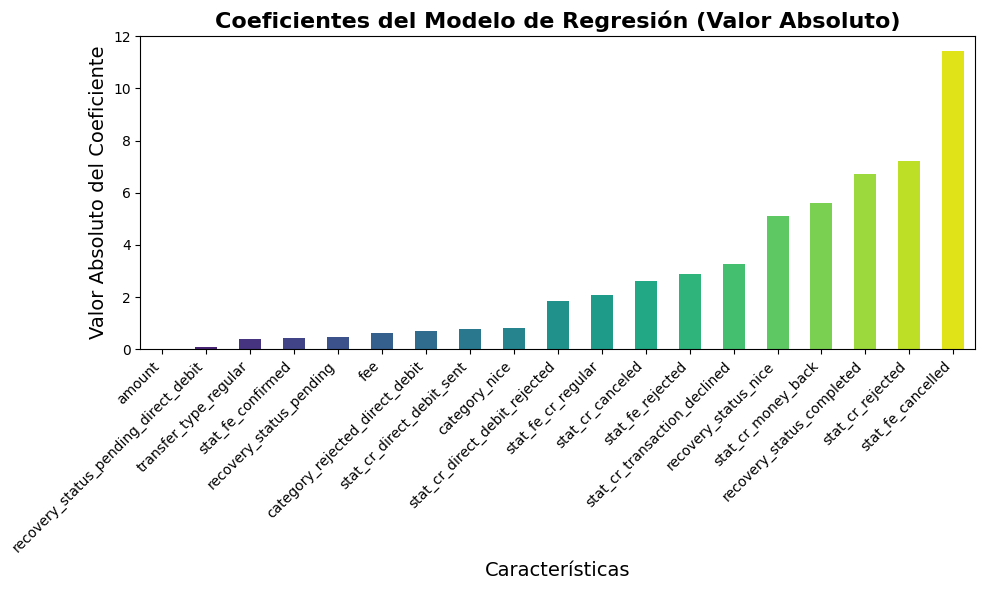

In [7]:
# Crear la gráfica de barras ordenada por valores absolutos de los coeficientes
plt.figure(figsize=(10, 6))
# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_clf.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_clf)))
# Título y etiquetas de ejes
plt.title('Coeficientes del Modelo de Regresión (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Rotación y alineación de las etiquetas para mejor legibilidad
plt.xticks(rotation=45, ha='right')
# Mostrar la gráfica
plt.tight_layout() # Ajustar el espaciado para evitar solapamiento de elementos
plt.show()

In [8]:
from sklearn import linear_model

ridge = linear_model.Ridge(alpha=1) # Inicializamos el regresor Ridge con una␣penalización de 1
ridge.fit(X_train, y_train) # Ajustamos el modelo a los datos de entrenamiento
# Extraemos los coeficientes y los ordenamos en función de su valor absoluto
coefs_ridge = pd.Series(np.abs(ridge.coef_), index=feature_names).sort_values(ascending=False)
# Realizamos la predicción en el conjunto de prueba y entrenamiento
y_train_pred_ridge = ridge.predict(X_train)
y_test_pred_ridge = ridge.predict(X_test)


Intercepto del modelo: 0.6666739752705774

Coeficientes del modelo Ridge:
 [ 6.23831862e-05  1.23070203e-02 -1.45244257e-03  6.94717020e-01
  8.30231737e-02  2.87896813e-02 -1.90897004e-01  7.83033724e-01
  7.25811196e-01  6.78221985e-01  3.19870864e-03 -1.21245868e-01
  3.16956549e-01  3.48679386e-01 -3.32978036e-01 -8.19525942e-02
  6.62512444e-02 -1.50203833e-01  7.56454428e-02]

Error Cuadrático Medio (MSE) en entrenamiento: 0.024131974286250475
Error Cuadrático Medio (MSE) en prueba: 0.025135845619471863

Puntaje R^2 en entrenamiento: 0.903303821884057
Puntaje R^2 en prueba: 0.8990386712946995


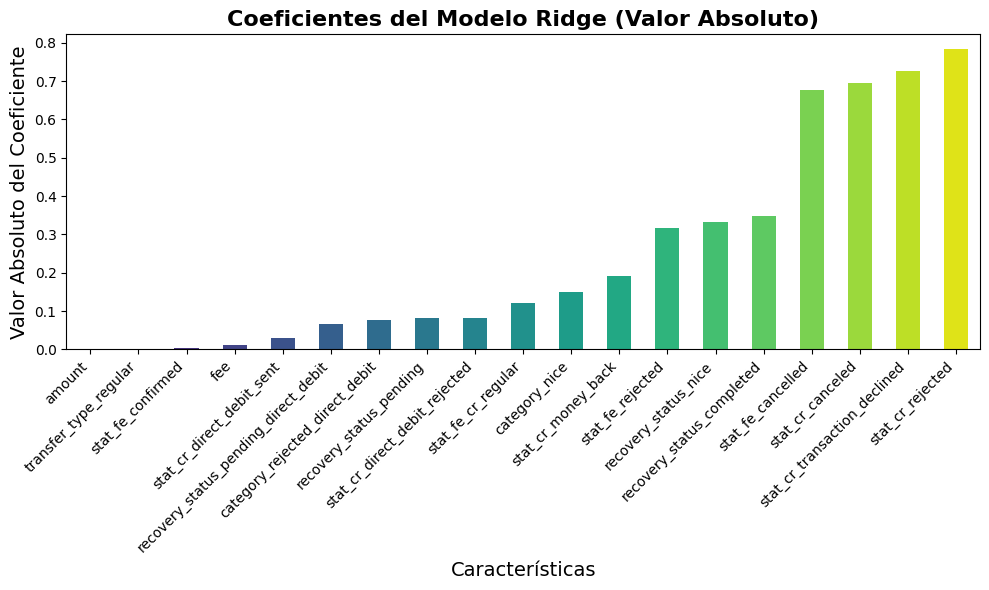

In [9]:
# Evaluación del modelo: calculamos el Error Cuadrático Medio (MSE) y el R^2
mse_ridge_train = mean_squared_error(y_train, y_train_pred_ridge) # MSE en␣entrenamiento
mse_ridge_test = mean_squared_error(y_test, y_test_pred_ridge) # MSE en prueba
r2score_ridge_train = ridge.score(X_train, y_train) # R^2 en entrenamiento
r2score_ridge_test = ridge.score(X_test, y_test) # R^2 en prueba
# Mostramos los resultados:
print('\nIntercepto del modelo:', ridge.intercept_)
print('\nCoeficientes del modelo Ridge:\n', ridge.coef_)
print('\nError Cuadrático Medio (MSE) en entrenamiento:', mse_ridge_train)
print('Error Cuadrático Medio (MSE) en prueba:', mse_ridge_test)
print('\nPuntaje R^2 en entrenamiento:', r2score_ridge_train)
print('Puntaje R^2 en prueba:', r2score_ridge_test)
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))
# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_ridge.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_ridge)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Ridge (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()


Intercepto del modelo: 0.5208584894636389

Coeficientes del modelo Lasso:
 [-0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0. -0.
  0.]

Error Cuadrático Medio (MSE) en entrenamiento: 0.24956492341729533
Error Cuadrático Medio (MSE) en prueba: 0.2490930363663965

Puntaje R^2 en entrenamiento: 0.0
Puntaje R^2 en prueba: -0.0005139394756334958


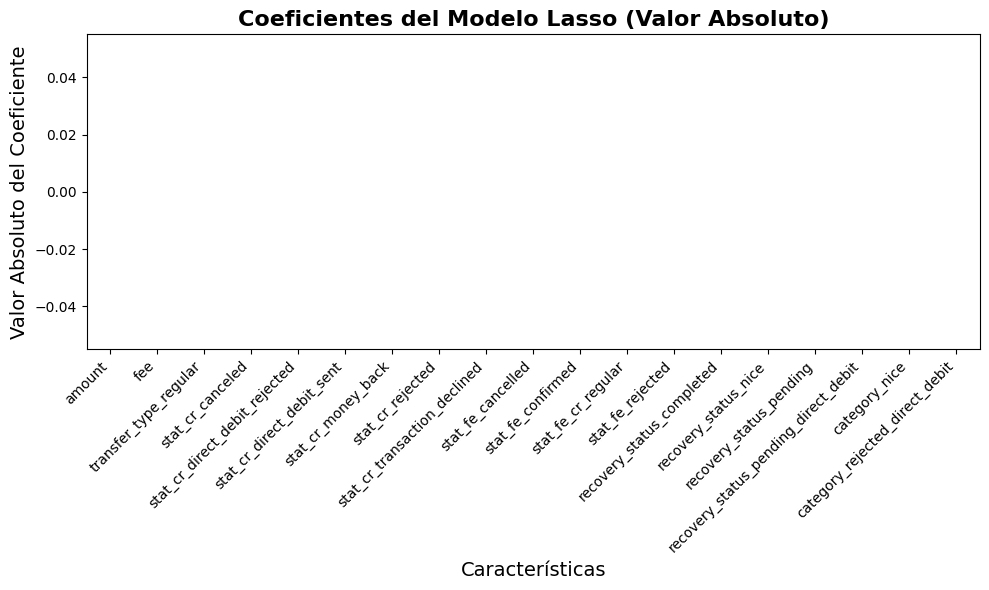

In [10]:
## Regresión Lasso
lasso = linear_model.Lasso(alpha=1) # Inicializamos el regresor Lasso con una␣penalización de 1
lasso.fit(X_train, y_train) # Ajustamos el modelo a los datos de entrenamiento
# Extraemos los coeficientes y los ordenamos en función de su valor absoluto
coefs_lasso = pd.Series(np.abs(lasso.coef_), index=feature_names).sort_values(ascending=False)
# Realizamos la predicción en los conjuntos de entrenamiento y prueba
y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)
# Evaluación del modelo: calculamos el Error Cuadrático Medio (MSE) y el R^2
mse_lasso_train = mean_squared_error(y_train, y_train_pred_lasso) # MSE en␣entrenamiento
mse_lasso_test = mean_squared_error(y_test, y_test_pred_lasso) # MSE en prueba
r2score_lasso_train = lasso.score(X_train, y_train) # R^2 en entrenamiento
r2score_lasso_test = lasso.score(X_test, y_test) # R^2 en prueba
# Mostramos los resultados:
print('\nIntercepto del modelo:', lasso.intercept_) # Imprimir el intercepto del modelo Lasso
print('\nCoeficientes del modelo Lasso:\n', lasso.coef_) # Imprimir los coeficientes del modelo Lasso
print('\nError Cuadrático Medio (MSE) en entrenamiento:', mse_lasso_train)
print('Error Cuadrático Medio (MSE) en prueba:', mse_lasso_test)
print('\nPuntaje R^2 en entrenamiento:', r2score_lasso_train)
print('Puntaje R^2 en prueba:', r2score_lasso_test)
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))
# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_lasso.sort_values(ascending=True).plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_lasso)))
# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Lasso (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

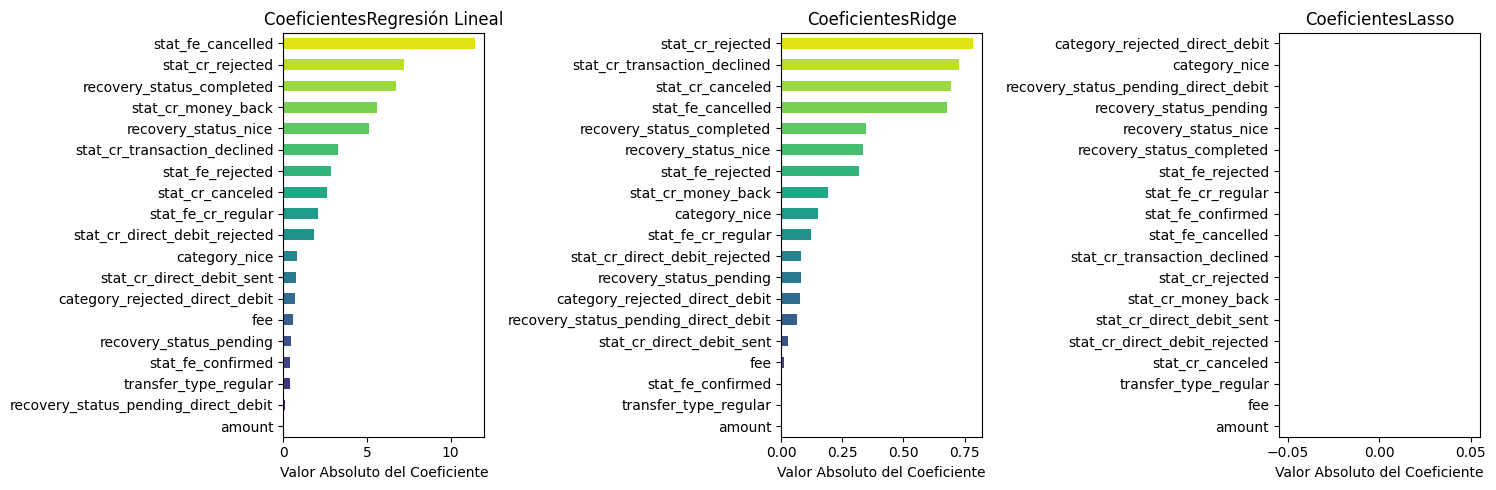

In [12]:
# Crear una figura de tamaño adecuado para visualizar los coeficientes
f = plt.figure(figsize=(15,5))
# Agregar los subgráficos
ax1 = f.add_subplot(131) # Primer gráfico para los coeficientes de la regresión lineal
ax2 = f.add_subplot(132) # Segundo gráfico para los coeficientes de Ridge

ax3 = f.add_subplot(133) # Tercer gráfico para los coeficientes de Lasso
# Graficar los coeficientes de cada modelo utilizando barras horizontales, ordenados de manera ascendente (menor a mayor)
coefs_clf.sort_values(ascending=True).plot(kind="barh", title='CoeficientesRegresión Lineal', ax=ax1, color=sns.color_palette("viridis",n_colors=len(coefs_clf))) # Coeficientes del modelo de regresión lineal
coefs_ridge.sort_values(ascending=True).plot(kind="barh", title='CoeficientesRidge', ax=ax2, color=sns.color_palette("viridis",n_colors=len(coefs_ridge))) # Coeficientes del modelo Ridge
coefs_lasso.sort_values(ascending=True).plot(kind="barh", title='CoeficientesLasso', ax=ax3, color=sns.color_palette("viridis",n_colors=len(coefs_lasso))) # Coeficientes del modelo Lasso
# Establecer etiquetas del eje X para cada gráfico
ax1.set_xlabel('Valor Absoluto del Coeficiente') # Etiqueta del eje X para el gráfico de regresión lineal
ax2.set_xlabel('Valor Absoluto del Coeficiente') # Etiqueta del eje X para el gráfico de Ridge
ax3.set_xlabel('Valor Absoluto del Coeficiente') # Etiqueta del eje X para el gráfico de Lasso
# Ajustar el espaciado entre los gráficos para que no se superpongan
plt.tight_layout()
# Mostrar la figura con los tres gráficos comparativos
plt.show()

In [13]:
print('Variables no importantes: {}'.format(coefs_lasso.index[coefs_lasso == 0].values)) # Imprimimos las variables con coeficientes cero (no importantes)
print('Variable más importante: {}'.format(coefs_lasso.index[-1])) #␣Imprimimos la variable más importante (con el coeficiente más alto)

Variables no importantes: ['amount' 'fee' 'transfer_type_regular' 'stat_cr_canceled'
 'stat_cr_direct_debit_rejected' 'stat_cr_direct_debit_sent'
 'stat_cr_money_back' 'stat_cr_rejected' 'stat_cr_transaction_declined'
 'stat_fe_cancelled' 'stat_fe_confirmed' 'stat_fe_cr_regular'
 'stat_fe_rejected' 'recovery_status_completed' 'recovery_status_nice'
 'recovery_status_pending' 'recovery_status_pending_direct_debit'
 'category_nice' 'category_rejected_direct_debit']
Variable más importante: category_rejected_direct_debit


In [15]:
# Cálculo de las métricas R² y MSE para cada modelo
scores = [
[r2score_train, r2score_test, r2score_train - r2score_test, mse_train,mse_test, mse_train - mse_test], # Regresión Lineal
[r2score_ridge_train, r2score_ridge_test, r2score_ridge_train - r2score_ridge_test, mse_ridge_train, mse_ridge_test, mse_ridge_train - mse_ridge_test], # Ridge
[r2score_lasso_train, r2score_lasso_test, r2score_lasso_train - r2score_lasso_test, mse_lasso_train, mse_lasso_test, mse_lasso_train - mse_lasso_test] # Lasso
]
# Creación del DataFrame con las métricas calculadas
df_scores = pd.DataFrame(scores,
columns=["R² Entrenamiento", "R² Prueba", "Δ R²(Entrenamiento - Prueba)",
"MSE Entrenamiento", "MSE Prueba", "Δ MSE(Entrenamiento - Prueba)"],
index=["Sin regularización", "Ridge", "Lasso"])
# Mostramos el DataFrame con los puntajes R² y MSE para comparar entre los modelos
df_scores # Visualizamos la comparación de puntajes R² y MSE entre los tres modelos, incluyendo sus diferencias

,R² Entrenamiento,R² Prueba,Δ R²(Entrenamiento - Prueba),MSE Entrenamiento,MSE Prueba,Δ MSE(Entrenamiento - Prueba)
Sin regularización,0.999922,1.000000,-0.000078,0.000078,0.000000,0.000078
Ridge,0.903304,0.899039,0.004265,0.024132,0.025136,-0.001004
Lasso,0.000000,-0.000514,0.000514,0.249565,0.249093,0.000472


In [17]:
# Ajustar el StandardScaler y transformar los datos de entrenamiento
scalerX = StandardScaler().fit(X_train)
X_train_std = scalerX.transform(X_train)
X_test_std = scalerX.transform(X_test)
# Crear un DataFrame para mostrar las estadísticas antes y después de la transformación
stats_before = {
'Mínimo': [np.min(X_train), np.min(X_test)],
'Máximo': [np.max(X_train), np.max(X_test)],
'Media': [np.mean(X_train), np.mean(X_test)],
'Varianza': [np.var(X_train), np.var(X_test)]
}
stats_after = {
'Mínimo': [np.min(X_train_std), np.min(X_test_std)],
'Máximo': [np.max(X_train_std), np.max(X_test_std)],
'Media': [np.mean(X_train_std), np.mean(X_test_std)],
'Varianza': [np.var(X_train_std), np.var(X_test_std)]
}

df_before = pd.DataFrame(stats_before, index=['Entrenamiento', 'Prueba'])
df_after = pd.DataFrame(stats_after, index=['Entrenamiento', 'Prueba'])
# Mostrar ambos DataFrames
print("\nEstadísticas antes de la transformación:")
df_before


Estadísticas antes de la transformación:


/home/albagd/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:4316: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,Mínimo,Máximo,Media,Varianza
Entrenamiento,0.0,200.0,4.751957,amount 672.54...
Prueba,0.0,200.0,4.771165,amount 663.82...


In [18]:
print("\nEstadísticas después de la transformación:")
df_after


Estadísticas después de la transformación:


,Mínimo,Máximo,Media,Varianza
Entrenamiento,-3.179335,31.407373,-8.983988e-18,1.000000
Prueba,-3.179335,31.407373,7.911438e-03,1.136708


In [19]:
print("\nDespués de la transformación:")
# Observar los valores máximos, mínimos, promedio y varianza de nuestros predictores estandarizados
import pandas as pd
import numpy as np
# Crear una lista para almacenar los resultados
resultados_std = []
# Iterar sobre los predictores y calcular las estadísticas
for i, feat in enumerate(feature_names):
    minimo = np.min(X_train_std[:, i]) # Usamos X_train_std, que ya está estandarizado
    maximo = np.max(X_train_std[:, i])
    media = np.mean(X_train_std[:, i])
    varianza = np.var(X_train_std[:, i])
    # Añadir los resultados a la lista
    resultados_std.append([feat, minimo, maximo, media, varianza])

# Crear un DataFrame para mostrar los resultados
df_estadisticas_std = pd.DataFrame(resultados_std, columns=['Predictores' ,'Mínimo', 'Máximo', 'Media', 'Varianza'])
# Mostrar el DataFrame
df_estadisticas_std


Después de la transformación:


,Predictores,Mínimo,Máximo,Media,Varianza
0,amount,-3.179335,4.494144,-2.741373e-16,1.0
1,fee,-1.377545,2.828903,5.009474e-17,1.0
2,transfer_type_regular,-0.801328,1.247929,-5.535331e-17,1.0
3,stat_cr_canceled,-0.032447,30.819667,-7.195930e-18,1.0
4,stat_cr_direct_debit_rejected,-0.252700,3.957267,3.002917e-17,1.0
5,stat_cr_direct_debit_sent,-0.044615,22.414106,2.656959e-17,1.0
6,stat_cr_money_back,-1.629908,0.613531,-3.238169e-17,1.0
7,stat_cr_rejected,-0.506893,1.972805,-3.459582e-17,1.0
8,stat_cr_transaction_declined,-0.036948,27.065001,1.024036e-17,1.0
9,stat_fe_cancelled,-0.426612,2.344048,-2.546252e-17,1.0


In [22]:
# Entrenar modelos
clf_std = linear_model.LogisticRegression()
ridge_std = linear_model.Ridge(alpha=.3)
lasso_std = linear_model.Lasso(alpha=.3)
clf_std.fit(X_train_std, y_train)
ridge_std.fit(X_train_std, y_train)
lasso_std.fit(X_train_std, y_train)
# Coeficientes de regresión
coefs_clf_std = pd.Series(np.abs(clf_std.coef_[0]), feature_names).sort_values()
coefs_ridge_std = pd.Series(np.abs(ridge_std.coef_), feature_names).sort_values()
coefs_lasso_std = pd.Series(np.abs(lasso_std.coef_), feature_names).sort_values()

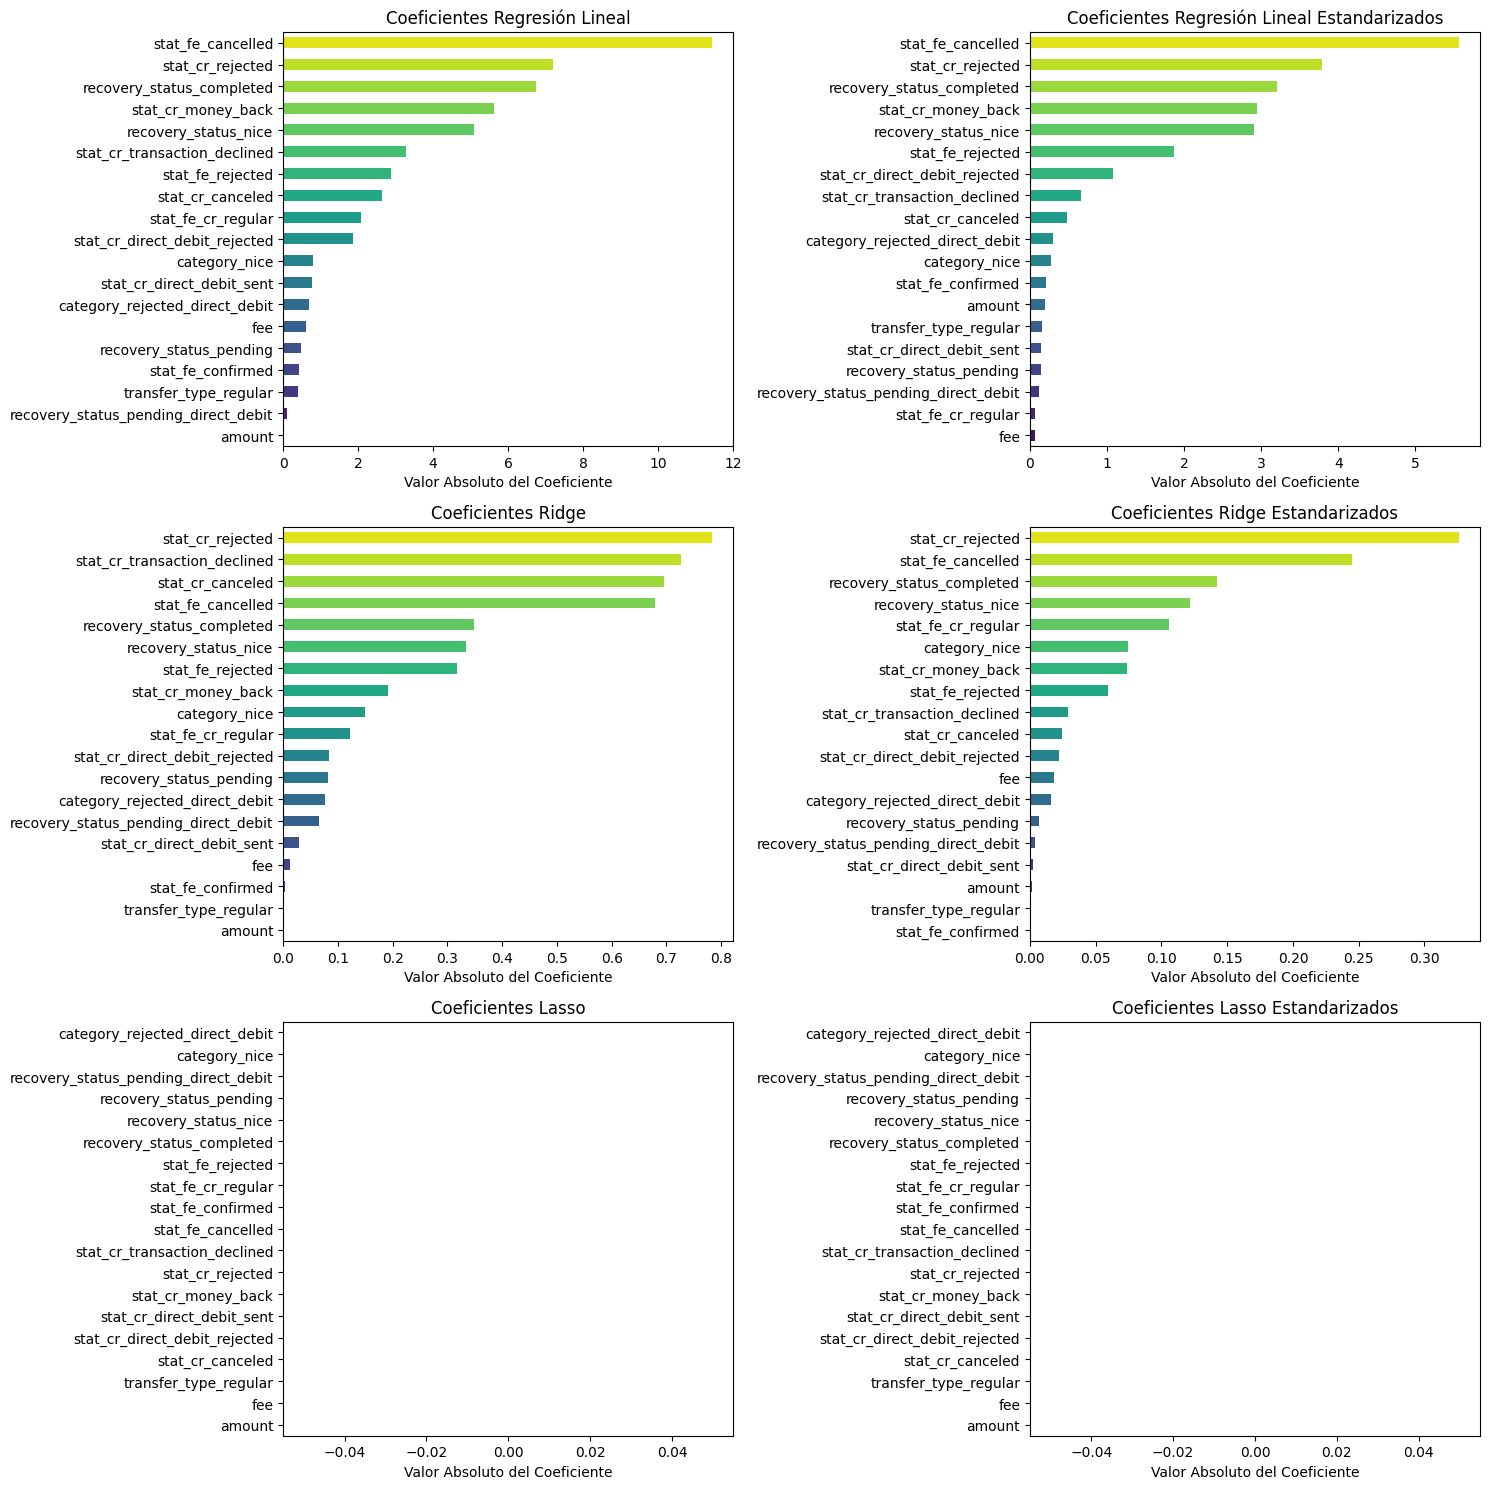

In [23]:
# Crear una figura de tamaño adecuado para visualizar los coeficientes en una disposición de 3x2
f = plt.figure(figsize=(15, 15))
# Agregar los subgráficos para cada modelo y cada tipo de coeficiente
ax1 = f.add_subplot(321) # Gráfico de coeficientes de regresión lineal
ax2 = f.add_subplot(322) # Gráfico de coeficientes estandarizados de regresión lineal
ax3 = f.add_subplot(323) # Gráfico de coeficientes de Ridge
ax4 = f.add_subplot(324) # Gráfico de coeficientes estandarizados de Ridge
ax5 = f.add_subplot(325) # Gráfico de coeficientes de Lasso
ax6 = f.add_subplot(326) # Gráfico de coeficientes estandarizados de Lasso
# Graficar los coeficientes de cada modelo utilizando barras horizontales, ordenados de menor a mayor
coefs_clf.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Regresión Lineal', ax=ax1,
color=sns.color_palette("viridis", n_colors=len(coefs_clf)))
coefs_clf_std.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Regresión Lineal Estandarizados', ax=ax2,
color=sns.color_palette("viridis", n_colors=len(coefs_clf_std)))
coefs_ridge.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Ridge', ax=ax3,
color=sns.color_palette("viridis", n_colors=len(coefs_ridge))
)
coefs_ridge_std.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Ridge Estandarizados', ax=ax4,
color=sns.color_palette("viridis", n_colors=len(coefs_ridge_std))
)
coefs_lasso.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Lasso', ax=ax5,
color=sns.color_palette("viridis", n_colors=len(coefs_lasso))
)
coefs_lasso_std.sort_values(ascending=True).plot(
kind="barh", title='Coeficientes Lasso Estandarizados', ax=ax6,
color=sns.color_palette("viridis", n_colors=len(coefs_lasso_std))
)
# Etiquetas del eje X para cada gráfico
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel('Valor Absoluto del Coeficiente')

# Ajustar el espaciado entre los gráficos para que no se superpongan
plt.tight_layout()
# Mostrar la figura con los seis gráficos comparativos
plt.show()

In [24]:
print('Variables no importantes:')
print('\nAntes de la transformación: {}'.format(sorted(coefs_lasso.index[coefs_lasso == 0].values)))
print('\nDespués de la transformación: {}'.format(sorted(coefs_lasso_std.index[coefs_lasso_std == 0].values)))
print('\nVariable más importante:')
print('\nAntes de la transformación: {}'.format(coefs_lasso.index[-1]))
print('\nDespués de la transformación: {}'.format(coefs_lasso_std.index[-1]))

Variables no importantes:

Antes de la transformación: ['amount', 'category_nice', 'category_rejected_direct_debit', 'fee', 'recovery_status_completed', 'recovery_status_nice', 'recovery_status_pending', 'recovery_status_pending_direct_debit', 'stat_cr_canceled', 'stat_cr_direct_debit_rejected', 'stat_cr_direct_debit_sent', 'stat_cr_money_back', 'stat_cr_rejected', 'stat_cr_transaction_declined', 'stat_fe_cancelled', 'stat_fe_confirmed', 'stat_fe_cr_regular', 'stat_fe_rejected', 'transfer_type_regular']

Después de la transformación: ['amount', 'category_nice', 'category_rejected_direct_debit', 'fee', 'recovery_status_completed', 'recovery_status_nice', 'recovery_status_pending', 'recovery_status_pending_direct_debit', 'stat_cr_canceled', 'stat_cr_direct_debit_rejected', 'stat_cr_direct_debit_sent', 'stat_cr_money_back', 'stat_cr_rejected', 'stat_cr_transaction_declined', 'stat_fe_cancelled', 'stat_fe_confirmed', 'stat_fe_cr_regular', 'stat_fe_rejected', 'transfer_type_regular']

Varia

In [26]:
# Evaluar los modelos y almacenar los resultados en un diccionario
scores = {
'Modelo': ['Regresión Lineal', 'Regresión Ridge', 'Regresión Lasso',
'Regresión Logistica (Estandarizada)', 'Regresión Ridge(Estandarizada)', 'Regresión Lasso (Estandarizada)'],
'R^2': [
clf.score(X_test, y_test),
ridge.score(X_test, y_test),
lasso.score(X_test, y_test),
clf_std.score(X_test_std, y_test),
ridge_std.score(X_test_std, y_test),
lasso_std.score(X_test_std, y_test)
]
}
# Crear el DataFrame
df_scores = pd.DataFrame(scores)
# Mostrar el DataFrame con los resultados
df_scores

,Modelo,R^2
0,Regresión Lineal,1.000000
1,Regresión Ridge,0.899039
2,Regresión Lasso,-0.000514
3,Regresión Logistica (Estandarizada),1.000000
4,Regresión Ridge(Estandarizada),0.899080
5,Regresión Lasso (Estandarizada),-0.000514
